# CytoDataFrame at a Glance

This notebook demonstrates various capabilities of
[CytoDataFrame](https://github.com/WayScience/CytoDataFrame) using examples.

CytoDataFrame is intended to provide you a Pandas-like
DataFrame experience which is enhanced with single-cell
visual information which can be viewed directly in a Jupyter notebook.

In [1]:
import pathlib

import pandas as pd

from cytodataframe.frame import CytoDataFrame

# create paths for use with CytoDataFrames below
jump_data_path = "../../../tests/data/cytotable/JUMP_plate_BR00117006"
nf1_cellpainting_path = "../../../tests/data/cytotable/NF1_cellpainting_data_shrunken/"
nuclear_speckles_path = "../../../tests/data/cytotable/nuclear_speckles"
pediatric_cancer_atlas_path = (
    "../../../tests/data/cytotable/pediatric_cancer_atlas_profiling"
)

CPU times: user 951 ms, sys: 696 ms, total: 1.65 s
Wall time: 555 ms


,Metadata_ImageNumber,Cells_Number_Object_Number,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigRNA
0,1,1,,,
1,1,2,,,
2,1,3,,,

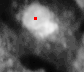
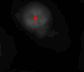
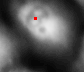
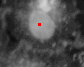
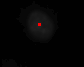
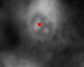
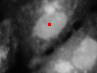
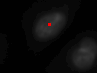
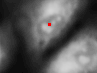

In [2]:
%%time
# view JUMP plate BR00117006 with images
CytoDataFrame(
    data=f"{jump_data_path}/BR00117006_shrunken.parquet",
    data_context_dir=f"{jump_data_path}/images/orig",
)[
    [
        "Metadata_ImageNumber",
        "Cells_Number_Object_Number",
        "Image_FileName_OrigAGP",
        "Image_FileName_OrigDNA",
        "Image_FileName_OrigRNA",
    ]
][:3]

CPU times: user 909 ms, sys: 706 ms, total: 1.61 s
Wall time: 497 ms


,Metadata_ImageNumber,Cells_Number_Object_Number,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigRNA
0,1,1,,,
1,1,2,,,
2,1,3,,,

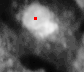
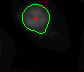
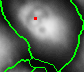
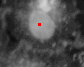
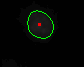
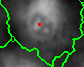
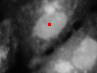
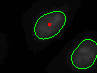
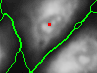

In [3]:
%%time
# view JUMP plate BR00117006 with images and overlaid outlines for segmentation
CytoDataFrame(
    data=f"{jump_data_path}/BR00117006_shrunken.parquet",
    data_context_dir=f"{jump_data_path}/images/orig",
    data_outline_context_dir=f"{jump_data_path}/images/outlines",
)[
    [
        "Metadata_ImageNumber",
        "Cells_Number_Object_Number",
        "Image_FileName_OrigAGP",
        "Image_FileName_OrigDNA",
        "Image_FileName_OrigRNA",
    ]
][:3]

CPU times: user 898 ms, sys: 677 ms, total: 1.57 s
Wall time: 495 ms


,Metadata_ImageNumber,Cells_Number_Object_Number,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigRNA
0,1,1,,,
1,1,2,,,
2,1,3,,,

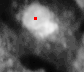
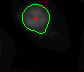
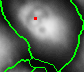
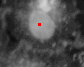
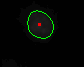
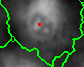
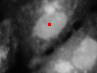
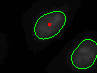
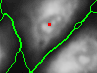

In [4]:
%%time
# view JUMP plate BR00117006 with images and change the display width
CytoDataFrame(
    data=f"{jump_data_path}/BR00117006_shrunken.parquet",
    data_context_dir=f"{jump_data_path}/images/orig",
    data_outline_context_dir=f"{jump_data_path}/images/outlines",
    display_options={"width": "100"},
)[
    [
        "Metadata_ImageNumber",
        "Cells_Number_Object_Number",
        "Image_FileName_OrigAGP",
        "Image_FileName_OrigDNA",
        "Image_FileName_OrigRNA",
    ]
][:3]

CPU times: user 903 ms, sys: 708 ms, total: 1.61 s
Wall time: 484 ms


,0,1,2,3,4
Metadata_ImageNumber,1,1,1,1,1
Cells_Number_Object_Number,1,2,3,4,5
Image_FileName_OrigAGP,,,,,
Image_FileName_OrigDNA,,,,,
Image_FileName_OrigRNA,,,,,

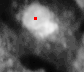
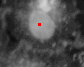
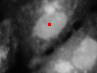
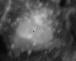
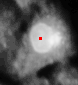
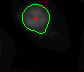
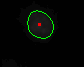
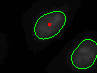
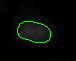
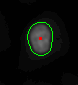
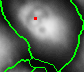
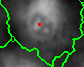
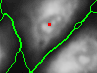
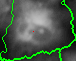
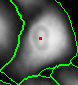

In [5]:
%%time
# view JUMP plate BR00117006 with images, change the display height and width
# and also transpose for a different view of things.
CytoDataFrame(
    data=f"{jump_data_path}/BR00117006_shrunken.parquet",
    data_context_dir=f"{jump_data_path}/images/orig",
    data_outline_context_dir=f"{jump_data_path}/images/outlines",
    display_options={"width": "200px", "height": "auto"},
)[
    [
        "Metadata_ImageNumber",
        "Cells_Number_Object_Number",
        "Image_FileName_OrigAGP",
        "Image_FileName_OrigDNA",
        "Image_FileName_OrigRNA",
    ]
][:5].T

CPU times: user 244 ms, sys: 161 ms, total: 405 ms
Wall time: 158 ms


,Metadata_ImageNumber,Metadata_Cells_Number_Object_Number,Image_FileName_GFP,Image_FileName_RFP,Image_FileName_DAPI
353,31,4,,,
1564,113,17,,,
1275,94,5,,,

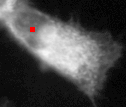
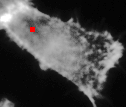
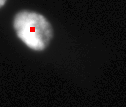
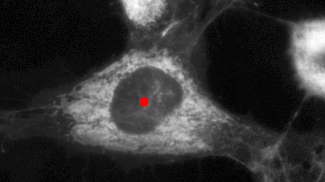
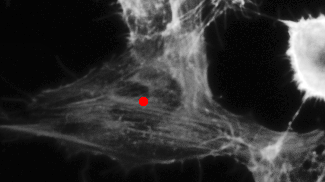
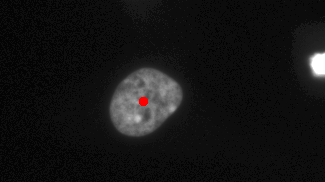
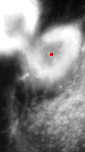
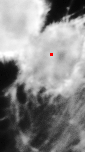
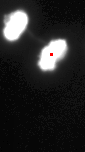

In [6]:
%%time
# view NF1 Cell Painting data with images
CytoDataFrame(
    data=f"{nf1_cellpainting_path}/Plate_2_with_image_data_shrunken.parquet",
    data_context_dir=f"{nf1_cellpainting_path}/Plate_2_images",
)[
    [
        "Metadata_ImageNumber",
        "Metadata_Cells_Number_Object_Number",
        "Image_FileName_GFP",
        "Image_FileName_RFP",
        "Image_FileName_DAPI",
    ]
][:3]

CPU times: user 291 ms, sys: 184 ms, total: 476 ms
Wall time: 190 ms


,Metadata_ImageNumber,Metadata_Cells_Number_Object_Number,Image_FileName_GFP,Image_FileName_RFP,Image_FileName_DAPI
353,31,4,,,
1564,113,17,,,
1275,94,5,,,

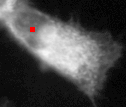
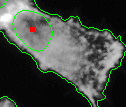
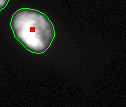
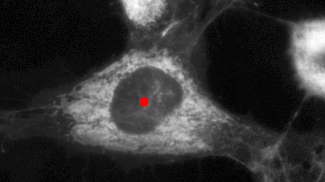
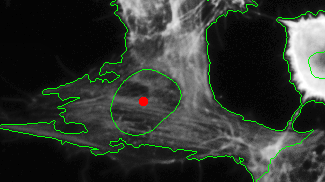
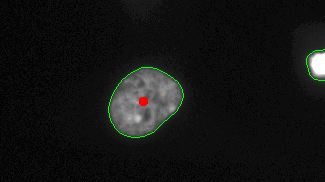
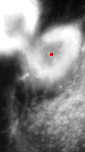
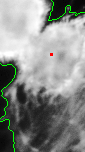
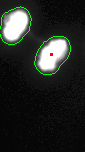

In [7]:
%%time
# view NF1 Cell Painting data with images and overlaid outlines from masks
CytoDataFrame(
    data=f"{nf1_cellpainting_path}/Plate_2_with_image_data_shrunken.parquet",
    data_context_dir=f"{nf1_cellpainting_path}/Plate_2_images",
    data_mask_context_dir=f"{nf1_cellpainting_path}/Plate_2_masks",
)[
    [
        "Metadata_ImageNumber",
        "Metadata_Cells_Number_Object_Number",
        "Image_FileName_GFP",
        "Image_FileName_RFP",
        "Image_FileName_DAPI",
    ]
][:3]

CPU times: user 290 ms, sys: 180 ms, total: 470 ms
Wall time: 177 ms


,Metadata_ImageNumber,Metadata_Cells_Number_Object_Number,Image_FileName_GFP,Image_FileName_RFP,Image_FileName_DAPI
353,31,4,,,
1564,113,17,,,
1275,94,5,,,

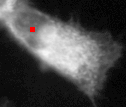
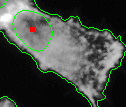
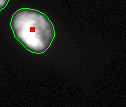
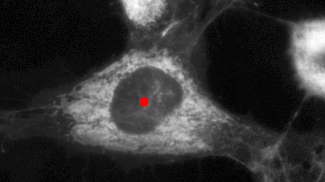
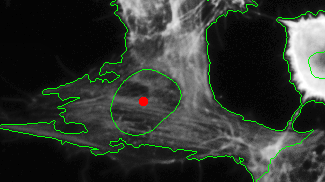
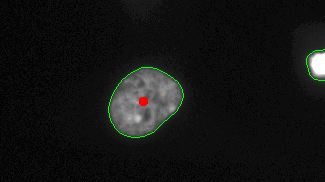
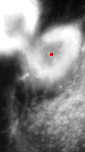
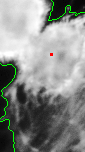
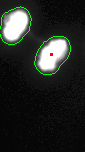

In [8]:
%%time
# add active paths on the local system to show how CytoDataFrame
# may be used without specifying a context directory for images.
# Note: normally these paths are local to the system where the
# profile data was generated, which often is not the same as the
# system which will be used to analyze the data.
parquet_path = f"{nf1_cellpainting_path}/Plate_2_with_image_data_shrunken.parquet"
nf1_dataset_with_modified_image_paths = pd.read_parquet(path=parquet_path)
nf1_dataset_with_modified_image_paths.loc[
    :, ["Image_PathName_DAPI", "Image_PathName_GFP", "Image_PathName_RFP"]
] = f"{pathlib.Path(parquet_path).parent}/Plate_2_images"

# view NF1 Cell Painting data with images and overlaid outlines from masks
CytoDataFrame(
    # note: we can read directly from an existing Pandas DataFrame
    data=nf1_dataset_with_modified_image_paths,
    data_mask_context_dir=f"{nf1_cellpainting_path}/Plate_2_masks",
)[
    [
        "Metadata_ImageNumber",
        "Metadata_Cells_Number_Object_Number",
        "Image_FileName_GFP",
        "Image_FileName_RFP",
        "Image_FileName_DAPI",
    ]
][:3]

CPU times: user 114 ms, sys: 76.9 ms, total: 191 ms
Wall time: 72.1 ms


,Metadata_ImageNumber,Nuclei_Number_Object_Number,Image_FileName_A647,Image_FileName_DAPI,Image_FileName_GOLD
0,1,1,slide1_A1_M10_CH1_Z09_illumcorrect.tiff,,slide1_A1_M10_CH2_Z09_illumcorrect.tiff
1,1,2,slide1_A1_M10_CH1_Z09_illumcorrect.tiff,,slide1_A1_M10_CH2_Z09_illumcorrect.tiff
2,1,3,slide1_A1_M10_CH1_Z09_illumcorrect.tiff,,slide1_A1_M10_CH2_Z09_illumcorrect.tiff

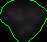
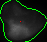

In [9]:
%%time
# view nuclear speckles data with images and overlaid outlines from masks
CytoDataFrame(
    data=f"{nuclear_speckles_path}/test_slide1_converted.parquet",
    data_context_dir=f"{nuclear_speckles_path}/images/plate1",
    data_mask_context_dir=f"{nuclear_speckles_path}/masks/plate1",
)[
    [
        "Metadata_ImageNumber",
        "Nuclei_Number_Object_Number",
        "Image_FileName_A647",
        "Image_FileName_DAPI",
        "Image_FileName_GOLD",
    ]
][:3]

CPU times: user 379 ms, sys: 269 ms, total: 649 ms
Wall time: 218 ms


,Metadata_ImageNumber,Metadata_Nuclei_Number_Object_Number,Image_FileName_OrigAGP,Image_FileName_OrigDNA
0,3,3,,
1,3,4,,
2,3,6,,
3,3,7,,
4,3,8,,

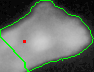
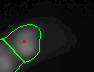
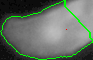
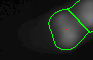
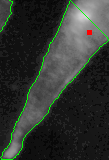
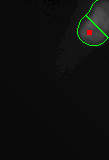
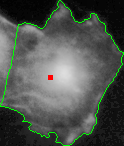
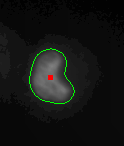
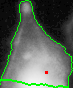
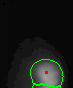

In [10]:
%%time
# view ALSF pediatric cancer atlas plate BR00143976 with images
CytoDataFrame(
    data=f"{pediatric_cancer_atlas_path}/BR00143976_shrunken.parquet",
    data_context_dir=f"{pediatric_cancer_atlas_path}/images/orig",
    data_outline_context_dir=f"{pediatric_cancer_atlas_path}/images/outlines",
    segmentation_file_regex={
        r"CellsOutlines_BR(\d+)_C(\d{2})_\d+\.tiff": r".*ch3.*\.tiff",
        r"NucleiOutlines_BR(\d+)_C(\d{2})_\d+\.tiff": r".*ch5.*\.tiff",
    },
)[
    [
        "Metadata_ImageNumber",
        "Metadata_Nuclei_Number_Object_Number",
        "Image_FileName_OrigAGP",
        "Image_FileName_OrigDNA",
    ]
]